In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [83]:
def gaussianKernel(x, y, theta, v, w, rho, sigma, A):

    Sigma = np.diag([rho, sigma])
    mu = np.array([v,w])

    x, y = np.meshgrid(x, y)

    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)

    pos = np.empty(x_rot.shape + (2,))
    pos[:, :, 0] = x_rot
    pos[:, :, 1] = y_rot

    const = A / (2 * np.pi * rho * sigma)
    
    Sigma_inv = np.linalg.inv(Sigma)

    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return const * np.exp(-fac / 2)

In [89]:
np.arange(-10,10)

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9])

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [85]:
np.cos(np.pi)

-1.0

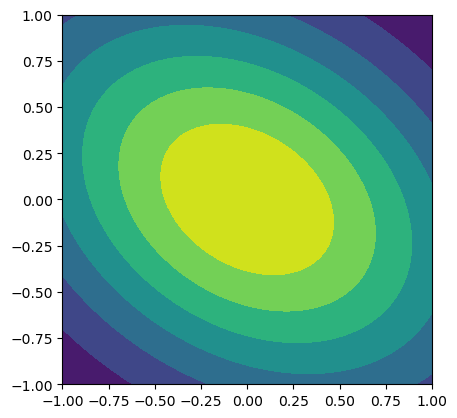

In [88]:
x = np.linspace(-1,1,51)
y = np.linspace(-1,1,51)

theta, v, w, rho, sigma, A = 1, 0, 0, 0.5, 1, 1

gk = gaussianKernel(x, y, theta, v, w, rho, sigma, A)


fig, ax = plt.subplots()
plt.contourf(x,y,gk)
ax.set_aspect('equal')

In [90]:
import torch

In [102]:
x = torch.rand(512,32,32)
z = x.reshape(1, *x.shape)
z[0] == x

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

In [94]:
x = torch.zeros(1,512,32,32)
y = torch.cat([x]*512, 0)
y.shape

torch.Size([512, 512, 32, 32])

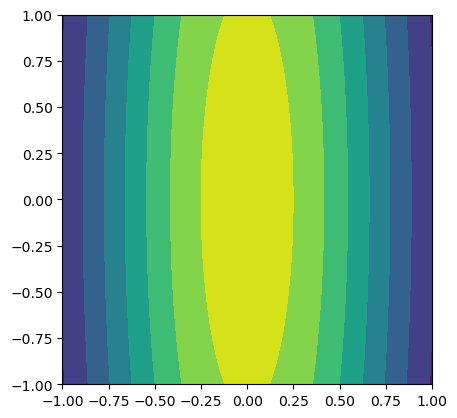